# Appendix: Neural *n*-gram model

A single layer FNN with weight $\boldsymbol{\mathsf W}$ of shape $|\mathcal{V}|^n$ can also be used to model *n*-grams. This weight tensor corresponds to the count matrix corresponding to the frequency of each *n*-gram.
The relevant row of weights is picked out by computing $\boldsymbol{\mathsf w}_a = \boldsymbol{\mathsf x}_a \boldsymbol{\mathsf W}$ where $\boldsymbol{\mathsf x}_a$ is the one-hot encoding of the input character $a.$ Then, we apply softmax to $\boldsymbol{\mathsf w}_a$ which is a common technique for converting real-valued vectors to probabilities.


In [1]:
from chapter import *

For concreteness, we implement a neural bigram model:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BigramNet(nn.Module):
    def __init__(self, vocab_size, alpha=0.1, seed=2147483647):
        super().__init__()
        self.vocab_size = vocab_size
        self.g = torch.Generator().manual_seed(seed)
        self.W = nn.Parameter(torch.randn((vocab_size, vocab_size), generator=self.g, requires_grad=True))
        self.alpha = alpha

    def forward(self, x):
        """Returns p(· | x) over characters."""
        xenc = F.one_hot(x, num_classes=self.vocab_size).float()
        logits = xenc.view(-1, self.vocab_size) @ self.W
        counts = logits.exp()
        probs = (counts + self.alpha) / (counts + self.alpha).sum(1, keepdim=True)
        return probs

The weights with values in `(-inf, +inf)` can be interpreted as **log-counts** of bigrams that start on the row index. This is interesting because growth in the negative direction is different from growth in the positive direction. Applying `.exp()` we get units of count with values in `(0, +inf)` which we interpret as counts. Normalizing these results in a probability vector.


```{figure} ../../../img/bigram-nn.drawio.svg
---
width: 450px
name: bigram-nn.drawio
align: center
---

Schematic diagram of the bigram neural net. Computing the probability assigned by the model on `b` given `a` which is represented here as one-hot vector. Note that this is also the backward dependence for a bigram `ab` encountered during training with the NLL loss.
```

<br>

## Model training

The model is initialized with uniform conditional probabilities. Then, it is trained to minimize next character NLL (i.e. maximize the likelihood of train bigrams). We expect similar performance with the *n*-gram count model which has the same capacity.

In [3]:
from tqdm.notebook import tqdm
from torch.optim import SGD
from torch.utils.data import DataLoader

names = load_surnames()
PAD_TOKEN = "."
vocab = Vocab(text="".join(names), preprocess=False, reserved_tokens=[PAD_TOKEN])

split_point = int(0.80 * len(names))
bigram_train = CharDataset(names[:split_point], block_size=1, vocab=vocab)
bigram_valid = CharDataset(names[split_point:], block_size=1, vocab=vocab)
train_loader = DataLoader(bigram_train, batch_size=256, shuffle=True)
valid_loader = DataLoader(bigram_valid, batch_size=256, drop_last=True)

model = BigramNet(vocab_size=len(vocab))
optim = SGD(model.parameters(), lr=10.0)

losses = []
num_steps = 500
for k in tqdm(range(num_steps)):
    x, y = next(iter(train_loader))
    p = model(x)
    loss = -p[torch.arange(len(y)), y].log().mean()  # next char nll

    loss.backward()
    optim.step()
    model.zero_grad()
    
    # logging
    losses.append(loss.item())

  0%|          | 0/500 [00:00<?, ?it/s]

 2.5613 (avg loss @ last 10 steps)


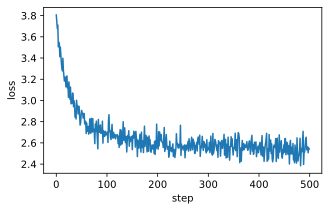

In [4]:
print(f"{sum(losses[-10:]) / 10: .4f}", "(avg loss @ last 10 steps)")
plt.figure(figsize=(5, 3))
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('step');

We get the expected validation performance:

In [5]:
loss = 0.0
for x, y in valid_loader:
    p = model(x)
    loss += -p[torch.arange(len(y)), y].log().sum()

B = x.shape[0]
print(loss / (len(valid_loader) * B))

tensor(2.5479, grad_fn=<DivBackward0>)


<br>

## Sampling

Generating names and its associated NLL:

In [6]:
s = []
for x in torch.tensor([[0, 1, 2], [3, 4, 5]]).tolist():
    s.append(bigram_train.tokenizer.decode(x))
s

['▮.a', 'ero']

In [7]:
def name_loss(name, model, dataset):
    nll = 0.0
    for c in name:
        x = torch.tensor(dataset.tokenizer.encode(c)).long().view(-1, 1)
        p = model(x)[0, dataset.vocab[c]]
        nll += -math.log(p)
    return nll / (len(name) + 1)

sample = list(filter(lambda n: len(n) >= 2, [generate_name(model, bigram_train, seed=_) for _ in range(12)]))
name_losses = {n: name_loss(n, model, bigram_train) for n in sample}
for n in sorted(sample, key=lambda n: name_losses[n]):
    print(f"{n:<50} {name_losses[n]:.3f}")

dr                                                 2.592
pwourza                                            3.890
gou                                                4.040
binatza                                            4.057
moz_dez                                            4.166
baz_do                                             4.206
beyhecurirrgharasezari                             4.238
bopin_sta                                          4.265
goyacipuesteral                                    4.308
benn_▮jose_o                                       4.362
larranabaizoandaiz_po                              4.365
chiu                                               4.418


<br>

Recall that instead of maximizing names, we are maximizing next character likelihood. Hence, we can get names with low NLL (relative to the random baseline) even if the name is unlikely to occur naturally[^1]. Consequently, it should be rare that a generated name is in the training dataset:

[^1]: Depending on the context, this can be considered as a strength of generative models.

In [8]:
print(r"Generated names found in train dataset:")
n = 1000
sample = [generate_name(model, bigram_train, seed=i) for i in range(n)]
print(f"{100 * sum([n in names for n in sample]) / n}% (n={n})")

Generated names found in train dataset:
4.7% (n=1000)


<br>

From the conditional distributions, it looks like the neural net recovered the count matrix!

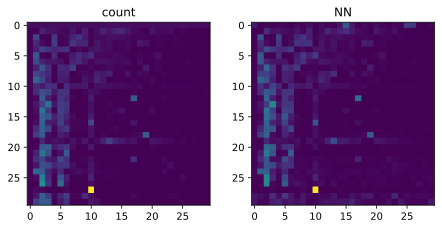

In [9]:
bigram_model = CountingModel(block_size=1, vocab_size=len(vocab))
bigram_model.fit(bigram_train)

counts = model.W.exp()
P = (counts / counts.sum(dim=1, keepdim=True)).data
P2 = bigram_model.P
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[0].imshow(P2)
ax[0].set_title("count")
ax[1].imshow(P)
ax[1].set_title("NN");